# Preliminary Analysis of Lead Pipes Data

In [7]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from sklearn.neighbors import BallTree

In [8]:
# Upload cleaned data set
df = pd.read_csv("df_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201679 entries, 0 to 201678
Data columns (total 16 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   Unnamed: 0                                                  201679 non-null  int64  
 1   PARCEL ID                                                   201679 non-null  object 
 2   YEARBLT                                                     201679 non-null  float64
 3   Street Number                                               201679 non-null  object 
 4   Street Name                                                 201679 non-null  object 
 5   City                                                        201679 non-null  object 
 6   Zip Code                                                    201679 non-null  object 
 7   County                                                      201679 non-nul

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_2642/807207090.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_cleaned.csv")


In [9]:
# Get stats on lead vs non-lead city service line material
lead_counts_city = df["System-Owned Portion Service Line Material Classification "].eq('PB').sum()
gal_counts_city = df["System-Owned Portion Service Line Material Classification "].eq('GAL').sum()
nonlead_counts_city = df["System-Owned Portion Service Line Material Classification "].isin(['CU','OT','PL']).sum()
unknown_counts_city = df["System-Owned Portion Service Line Material Classification "].eq('MU').sum()

p_lead = lead_counts_city/(lead_counts_city+nonlead_counts_city+gal_counts_city)

print("City Service Line Summary")
print(f"Properties with lead pipes: {lead_counts_city}")
print(f"Properties with galvanized pipes: {gal_counts_city}")
print(f"Properties with non-lead pipes: {nonlead_counts_city}")
print(f"Properties with galvanized pipes: {gal_counts_city}")
print(f"Properties with unknown service line material: {unknown_counts_city}")

City Service Line Summary
Properties with lead pipes: 17277
Properties with galvanized pipes: 3418
Properties with non-lead pipes: 180984
Properties with galvanized pipes: 3418
Properties with unknown service line material: 0


In [10]:
df.sample(n=10)

,Unnamed: 0,PARCEL ID,YEARBLT,Street Number,Street Name,City,Zip Code,County,Latitude,Longitude,System-Owned Portion Service Line Material Classification,is_lead,is_lead_pm,nn_is_lead,nn_distance_km,nn_is_lead_weighted
47916,54950,010-080064,1947.0,2889,DRESDEN ST,COLUMBUS,43224-4206,FRANKLIN,40.025754,-82.971451,PB,1,1,1,0.011360,80.907970
137359,161873,010-297881,2018.0,6780,SAWYERS CREEK RD,WESTERVILLE,43081,FRANKLIN,40.104728,-82.834720,CU,0,-1,-1,0.013667,-68.178466
191136,24490,070-000943,1956.0,2368,NW ARLINGTON AVE,COLUMBUS,43221-3749,FRANKLIN,40.004156,-83.067439,CU,0,-1,-1,0.019789,-48.101828
32086,36818,240-005678,1984.0,6636,CEDAR CT,GALLOWAY,43119-9594,FRANKLIN,39.923816,-83.173001,OT,0,-1,-1,0.022302,-42.914859
165993,194711,490-256638,2006.0,5543,WINCHESTER MEADOWS DR,CANAL WINCHESTER,43110-8201,FRANKLIN,39.869223,-82.811359,OT,0,-1,-1,0.016157,-58.284419
26917,31004,140-002208,1930.0,1500,BROWN RD,COLUMBUS,43223-3319,FRANKLIN,39.925891,-83.038118,CU,0,-1,-1,0.036711,-26.517260
34401,39438,070-000652,2012.0,2156,CHESHIRE RD,UPPER ARLINGTON,43221,FRANKLIN,39.999576,-83.067852,CU,0,-1,-1,0.015198,-61.735264
9436,11121,010-077550,1924.0,119,AMAZON PL,COLUMBUS,43214-3503,FRANKLIN,40.040200,-83.021596,PB,1,1,1,0.011902,77.505610
158274,185603,070-002358,1953.0,1927,W LANE AVE,COLUMBUS,43221-3250,FRANKLIN,40.007270,-83.061934,CU,0,-1,-1,0.018031,-52.545600
119896,141361,610-179333,1982.0,7500,PLACID AVE,WORTHINGTON,43085-1517,FRANKLIN,40.119853,-82.980914,PL,0,-1,-1,0.019517,-48.740667


### Study the "YEARBLT" feature's influence on the target "is_lead" 

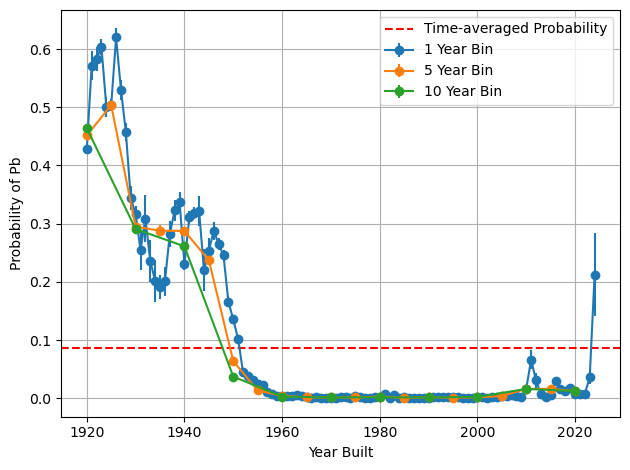

In [12]:
def get_yearbuilt_stats(df, binsize):
    # Bin years
    df["year_vals"] = (df["YEARBLT"] // binsize) * binsize
    
    # Clip all data before 1920 
    df["year_vals"] = df["year_vals"].clip(lower=1920) 

    # Compute stats
    grouped = df.groupby("year_vals")["is_lead"]
    average_by_year = grouped.mean()
    counts_by_year = grouped.count()
    std_by_year = np.sqrt(average_by_year * (1 - average_by_year) / counts_by_year)

    # Reset index to make plotting easier
    stats_df = pd.DataFrame({
        "year": average_by_year.index,
        "average": average_by_year.values,
        "count": counts_by_year.values,
        "std": std_by_year.values
    })

    # Clean up
    df.drop("year_vals", axis=1, inplace=True)

    return stats_df

# Run for different bin sizes
stats_01 = get_yearbuilt_stats(df.copy(), 1)
stats_05 = get_yearbuilt_stats(df.copy(), 5)
stats_10 = get_yearbuilt_stats(df.copy(), 10)



# Plot probability of having lead pipes for different bin sizes
plt.errorbar(stats_01["year"], stats_01["average"], yerr=stats_01["std"], fmt='o-', label='1 Year Bin')
plt.errorbar(stats_05["year"], stats_05["average"], yerr=stats_05["std"], fmt='o-', label='5 Year Bin')
plt.errorbar(stats_10["year"], stats_10["average"], yerr=stats_10["std"], fmt='o-', label='10 Year Bin')
plt.axhline(y=p_lead, color='r', linestyle='--', label='Time-averaged Probability')
plt.xlabel("Year Built")
plt.ylabel("Probability of Pb")
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig("averageLead_per_year.png", dpi=201)
plt.show()

Notes on the plot:

Seems to be a sharp drop off during the period from 1930-1960, which matches with timing of legislation. 

Some "outliers" to logistic regression located in 2010-2024. These are likely from new homes built in historic neighborhoods

Logistic regression could capture this trend. Appears that homes built before 1930 have ~50% chance of having lead service lines. After 1960, that probability drops to nearly zero. 


## Study the 2-point correlation function vs distance

Note: this data set is too large to calculate the exact correlation function. So, it is approximated using Monte-Carlo sampling of point pairs in the data set. 

Note: the correlation is taken for the variable "is_lead_pm" to capture correlations between non-lead properties as well as lead properties. 

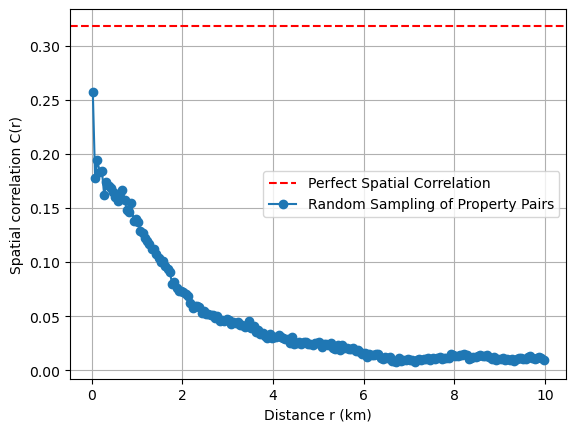

In [13]:
# Preprocessing (same as before)
df['lat_rad'] = np.radians(df['Latitude'])
df['lon_rad'] = np.radians(df['Longitude'])
coords = df[['lat_rad', 'lon_rad']].to_numpy()
lead = df['is_lead_pm'].to_numpy()
mu = np.mean(lead)
lead_dev = lead - mu

# Parameters
n_samples = 100_000_000  # number of pairs to sample
bin_edges_km = np.linspace(0, 10.0, 201) #np.linspace(0, 2.0, 41)  # 40 bins, 50m wide
bin_centers = 0.5 * (bin_edges_km[:-1] + bin_edges_km[1:])
bin_edges_rad = bin_edges_km / 6371.0

# pick out random points
N = len(coords)
sample_i = np.random.randint(0, N, size=n_samples)
sample_j = np.random.randint(0, N, size=n_samples)
mask = sample_i != sample_j  # avoid self-pairs
sample_i = sample_i[mask]
sample_j = sample_j[mask]

lat1 = coords[sample_i][:, 0]
lon1 = coords[sample_i][:, 1]
lat2 = coords[sample_j][:, 0]
lon2 = coords[sample_j][:, 1]

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
distances_km = 6371.0 * c

from scipy.stats import binned_statistic

products = lead_dev[sample_i] * lead_dev[sample_j]
correlation, _, _ = binned_statistic(
    distances_km, products, statistic='mean', bins=bin_edges_km)
counts, _, _ = binned_statistic(
    distances_km, products, statistic='count', bins=bin_edges_km)

# Calculate "ideal" correlation value
p_lead = lead_counts_city/(lead_counts_city+nonlead_counts_city)
correlation_ideal = 4*(p_lead-p_lead**2)

plt.axhline(y=correlation_ideal, color='r', linestyle='--', label='Perfect Spatial Correlation')
plt.plot(bin_centers, correlation, marker='o', label='Random Sampling of Property Pairs')
plt.xlabel('Distance r (km)')
plt.ylabel('Spatial correlation C(r)')
plt.grid(True)
#plt.title('Approximate Spatial Correlation')
plt.savefig("spatial_correlation.png", dpi=201)
plt.legend()
plt.show()

Notes from the plot:

The 2-point correlation function $C(r) = \langle s(R) s(R+r) \rangle - \langle s(R) \rangle \langle s(R+r) \rangle$ measures the degree of correlation in the "is_lead_pm" (denoted by $s$) variable between all properties located some distance $r$ away from each other. 

For any two pairs of points $s_i = \pm 1$ and $s_j \pm 1$, $(s_i s_j) = +1$ if they have the same value, and $-1$ is the values are different. 

The expected value of "is_lead_pm" is given by $\langle s(R) \rangle = p_l - p_{nl} = 2p_l -1$, where $p_l$ and $p_{nl}$ are the probabilities of having lead and non-lead pipes, respectively, and $p_l + p_{nl} = 1$. 

If the data were completely uncorrelated, then $C(r) \rightarrow 0$. This provides a lower bound for the correlation function

We can imagine a "perfectly" correlated toy model wherein all of the lead and non-lead homes in the dataset are spatially segregated into two neighborhoods. Say these neighborhoods each have a radius less than some cutoff radius $R_c$, but the distance between these neighborhoods is far compared to $R_c$. Then we can show that for this toy model, $C(r<R_c) = 4(p_l-p_l^2)$ and $C(r>R_c) = -2 + 4(p_l-p_l^2)$. This former value sets the "upper bound" for our correlation data, and is given by the dashed red line in the plot. 

We see that spatial correlation is a (roughly) monotonically decreasing function of distance, with maximum spatial correlation achieved for the smallest bin, ranging from 0-50 meters. Therefore, this plot provides justification for performing knn and utilizing nearest neighbor "is_lead" values to inform our model. 

